# EECS 498-007/598-005 Assignment 5-1: Single-Stage Object Detector - YOLO

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Firstname Lastname, #UMID

# Single-Stage Object Detector
In this exercise you will implement a **single-stage** object detector, based on YOLO ([v1](https://arxiv.org/pdf/1506.02640.pdf) and [v2](https://arxiv.org/pdf/1612.08242.pdf)) and use it to train a model that can detect objects on novel images. We will also evaluate the detection accuracy using the classic metric mean Average Precision ([mAP](https://github.com/Cartucho/mAP)). In Part II of A5, you will implement a **two-stage** object detector, based on [Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf). The main difference between the two is that single-stage detectors perform region proposal and classification simultaneously while two-stage detectors have them decoupled. 

# 01-Getting Started

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as previous assignments. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['single_stage_detector_yolo.ipynb', 'two_stage_detector_faster_rcnn.ipynb', 'eecs598', 'single_stage_detector.py', 'two_stage_detector.py', 'a5_helper.py']
```

In [ ]:
# import os

# # TODO: Fill in the Google Drive path where you uploaded the assignment
# # Example: If you create a 2020FA folder and put all the files under A5 folder, then '2020FA/A5'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
# GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
# print(os.listdir(GOOGLE_DRIVE_PATH))

Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from single_stage_detector.py!
Hello from a5_helper.py!
```

as well as the last edit time for the file `single_stage_detector.py`.

In [2]:
# import sys
# sys.path.append(GOOGLE_DRIVE_PATH)

# import time, os
# os.environ["TZ"] = "US/Eastern"
# time.tzset()

from single_stage_detector import hello_single_stage_detector
hello_single_stage_detector()

from a5_helper import hello_helper
hello_helper()

# single_stage_detector_path = os.path.join(GOOGLE_DRIVE_PATH, 'single_stage_detector.py')
# single_stage_detector_edit_time = time.ctime(os.path.getmtime(single_stage_detector_path))
# print('single_stage_detector.py last edited on %s' % single_stage_detector_edit_time)

Hello from single_stage_detector.py!
Hello from a5_helper.py!


Load several useful packages that are used in this notebook:

In [3]:
import eecs598
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import statistics
import random
import time
import math
import numpy as np
import cv2
import copy
import shutil
import os
import json

import matplotlib.pyplot as plt
%matplotlib inline

from eecs598 import reset_seed, Solver
from eecs598.grad import rel_error

from a5_helper import *

# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for mAP evaluation
!rm -rf mAP
!git clone https://github.com/Cartucho/mAP.git
!rm -rf mAP/input/*

Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 829.00 KiB/s, done.
Resolving deltas: 100% (321/321), done.
Updating files: 100% (269/269), done.


We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [4]:
if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Please set GPU via Edit -> Notebook Settings.


## Load PASCAL VOC 2007 data
During the majority of our homework assignments so far, we have used the CIFAR-10 dataset for image classification tasks.

We will need to use a new dataset for object detection. In order to train and evaluate object detection models, we need a dataset where each image is annotated with a *set* of *bounding boxes*, where each box gives the category label and spatial extent of some object in the image.

We will use the [PASCAL VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/) dataset, which provides annotations of this form. PASCAL VOC ran a series of yearly computer vision competitions from 2005 to 2012, predating the ImageNet challenge which we have discussed in class.

The data from the 2007 challenge used to be one of the most popular datasets for evaluating object detection. It is much smaller than more recent object detection datasets such as [COCO](http://cocodataset.org/#home), and thus easier to manage in an homework assignment.

The function `get_pascal_voc2007_data` in `a5_helper.py` will download the PASCAL VOC 2007 dataset and return it as a PyTorch Dataset object. Run the following cell to download the training and validation sets for the PASCAL VOC 2007 dataset.

The [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) objects returned from the above function returns annotations for each image as a nested set of dictionary objects.

In [5]:
# uncomment below to use the mirror link if the original link is broken and move it to GOOGLE_DRIVE_PATH
# !wget https://web.eecs.umich.edu/~justincj/data/VOCtrainval_06-Nov-2007.tar
# shutil.move('VOCtrainval_06-Nov-2007.tar', os.path.join(GOOGLE_DRIVE_PATH, 'VOCtrainval_06-Nov-2007.tar'))  
# train_dataset = get_pascal_voc2007_data(GOOGLE_DRIVE_PATH, 'train')
# val_dataset = get_pascal_voc2007_data(GOOGLE_DRIVE_PATH, 'val')
train_dataset = get_pascal_voc2007_data('./datasets', 'train')
val_dataset = get_pascal_voc2007_data('./datasets', 'val')

# an example on the raw annotation
print(json.dumps(train_dataset[1][1]['annotation'], indent=2))

{
  "folder": "VOC2007",
  "filename": "000017.jpg",
  "source": {
    "database": "The VOC2007 Database",
    "annotation": "PASCAL VOC2007",
    "image": "flickr",
    "flickrid": "228217974"
  },
  "owner": {
    "flickrid": "genewolf",
    "name": "whiskey kitten"
  },
  "size": {
    "width": "480",
    "height": "364",
    "depth": "3"
  },
  "segmented": "0",
  "object": [
    {
      "name": "person",
      "pose": "Left",
      "truncated": "0",
      "difficult": "0",
      "bndbox": {
        "xmin": "185",
        "ymin": "62",
        "xmax": "279",
        "ymax": "199"
      }
    },
    {
      "name": "horse",
      "pose": "Left",
      "truncated": "0",
      "difficult": "0",
      "bndbox": {
        "xmin": "90",
        "ymin": "78",
        "xmax": "403",
        "ymax": "336"
      }
    }
  ]
}


In order to use these annotations to train our model, we need to convert this nested dictionary data structure into a set of PyTorch tensors.

We also need to preprocess the image, converting it to a PyTorch tensor and resizing it to 224x224. Real object detection systems typically work with much higher-resolution images, but we will use a low resolution for computational efficiency in this assignment.

We also want to train our models using minibatches of data, so we need to group the annotations from several images into minibatches.

We perform both of these functions by using a customized PyTorch [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) object, which we have written for you. Those functions are all available in `a5_helper.py`. 

Training with the entire PASCAL VOC will be too computationally expensive for this homework assignment, so we can subsample the dataset by wrapping each `Dataset` object in a [`Subset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset) object:

In [6]:
train_dataset = torch.utils.data.Subset(train_dataset, torch.arange(0, 2500)) # use 2500 samples for training
train_loader = pascal_voc2007_loader(train_dataset, 10)
val_loader = pascal_voc2007_loader(val_dataset, 10)

The `DataLoader` objects return batches of data.

The first output from the `DataLoader` is a Tensor `img` of shape `(B, 3, 224, 224)`. This is a batch of `B` images, similar to what we have seen in classification datasets.

The second output from the `DataLoader` is a Tensor `ann` of shape `(B, N, 5)` giving information about all objects in all images of the batch. `ann[i, j] = (x_tl, y_tl, x_br, y_br, class)` gives information about the `j`th object in `img[i]`. The position of the top-left corner of the box is `(x_tl, y_tl)` and the position of the bottom-right corner of the box is `(x_br, y_br)`. These positions are in the coordinate system of the original image (before it was resized to 224 x 224). `class` is an integer giving the category label for this bounding box.

Each image can have different numbers of objects. If `img[i]` has $N_i$ objects, then $N=\max_i N_i$ is the maximum number of objects per image among all objects in the batch; this value can vary from batch to batch. For the images that have fewer than $N$ annotated objects, only the first $N_i$ rows of $anns[i]$ contain annotations; the remaining rows are padded with -1.

In [7]:
train_loader_iter = iter(train_loader)
img, ann, _, _, _ = train_loader_iter.next()

print('img has shape: ', img.shape)
print('ann has shape: ', ann.shape)

print('Image 1 has only two annotated objects, so ann[1] is padded with -1:')
print(ann[1])

print('\nImage 2 has six annotated objects:, so ann[2] is not padded:')
print(ann[2])

print('\nEach row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).')

img has shape:  torch.Size([10, 3, 224, 224])
ann has shape:  torch.Size([10, 6, 5])
Image 1 has only two annotated objects, so ann[1] is padded with -1:
tensor([[185.,  62., 279., 199.,  14.],
        [ 90.,  78., 403., 336.,  12.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.]])

Image 2 has six annotated objects:, so ann[2] is not padded:
tensor([[  9., 230., 245., 500.,   1.],
        [230., 220., 334., 500.,   1.],
        [  2., 178.,  90., 500.,   1.],
        [  2.,   1., 117., 369.,  14.],
        [  3.,   2., 243., 462.,  14.],
        [225.,   1., 334., 486.,  14.]])

Each row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).


### ===DEBUGGING===

So we may see:
- length of our dataset is in fact 2500; we can index this dataset and get the first element;
- we have an image and a label for it; the image has high resolution - `(500, 333)`; 
- coordinate system and bounding box coordinates are not what we want, so we have to modify them;
- in general labels are not that easy as we had in case of image classification;

In [ ]:
len(train_dataset)

In [ ]:
type(train_dataset[0]), len(train_dataset[0])

In [ ]:
x, y = train_dataset[0]

In [ ]:
type(x), type(y)

In [ ]:
x.size

In [ ]:
y.keys()

In [ ]:
plt.imshow(x);

In [ ]:
type(y["annotation"]), y["annotation"].keys()

In [ ]:
y["annotation"]["size"], y["annotation"]["segmented"], type(y["annotation"]["object"])

In [ ]:
type(y["annotation"]["object"][0])

In [ ]:
y["annotation"]["object"][0].keys()

In [ ]:
y["annotation"]["object"][0]["bndbox"]

So what about data loader? We may see that:
- batch size is quite small - just 10 images in a batch;
- images are resized - 224x224; as mentioned before that's much smaller than in real models and it's just for simplicity;
- we now have 5 numbers in a label for each image: 4 numbers for bbox and we still need 1 number for a class; they use different (from lectures) approach to bbox - coordinates for top-left corner and bottom-right; we'll probably change this (see the next function);
- we also can get the size of original image; we also have image names; it seems bbox numbers are provided in the old image and that's maybe the reason we need all this information; 

In [ ]:
xb, yb, z1, z2, z3 = train_loader_iter.next()

In [ ]:
type(xb), type(yb), type(z1), type(z2), type(z3)

In [ ]:
xb.shape, yb.shape

In [ ]:
yb[0]

In [ ]:
yb[1]

In [ ]:
z1.shape, z2.shape

In [ ]:
z1, z2

In [ ]:
len(z3)

In [ ]:
z3

# Coordinate transformation
It's a good practice to use a consistent coordinate system for all the spatial-related computations (e.g., anchors, proposals). **In this assignment, we use the coordinate system defined by the CNN activation map (of shape 7x7), where the top-left corner is (0, 0) and the bottom-right corner is (7, 7). The horizontal axis is the x axis and the vertical axis is the y axis.**

The following function defines the transformation from the original image coordinate system (pixels, and the top-left corner is (0, 0)) to the activation map coordinate system and vice versa. You can find the function in `a5_helper.py`

```python
def coord_trans(bbox, w_pixel, h_pixel, w_amap=7, h_amap=7, mode='a2p'):
  """
  Coordinate transformation function. It converts the box coordinate from
  the image coordinate system to the activation map coordinate system and vice versa.
  In our case, the input image will have a few hundred of pixels in
  width/height while the activation map is of size 7x7.

  Input:
  - bbox: Could be either bbox, anchor, or proposal, of shape Bx*x4
  - w_pixel: Number of pixels in the width side of the original image, of shape B
  - h_pixel: Number of pixels in the height side of the original image, of shape B
  - w_amap: Number of pixels in the width side of the activation map, scalar
  - h_amap: Number of pixels in the height side of the activation map, scalar
  - mode: Whether transfer from the original image to activation map ('p2a') or
          the opposite ('a2p')

  Output:
  - resized_bbox: Resized box coordinates, of the same shape as the input bbox
  """

  assert mode in ('p2a', 'a2p'), 'invalid coordinate transformation mode!'
  assert bbox.shape[-1] >= 4, 'the transformation is applied to the first 4 values of dim -1'
  
  if bbox.shape[0] == 0: # corner cases
    return bbox

  resized_bbox = bbox.clone()
  # could still work if the first dim of bbox is not batch size
  # in that case, w_pixel and h_pixel will be scalars
  resized_bbox = resized_bbox.view(bbox.shape[0], -1, bbox.shape[-1])
  invalid_bbox_mask = (resized_bbox == -1) # indicating invalid bbox

  if mode == 'p2a':
    # pixel to activation
    width_ratio = w_pixel * 1. / w_amap
    height_ratio = h_pixel * 1. / h_amap
    resized_bbox[:, :, [0, 2]] /= width_ratio.view(-1, 1, 1)
    resized_bbox[:, :, [1, 3]] /= height_ratio.view(-1, 1, 1)
  else:
    # activation to pixel
    width_ratio = w_pixel * 1. / w_amap
    height_ratio = h_pixel * 1. / h_amap
    resized_bbox[:, :, [0, 2]] *= width_ratio.view(-1, 1, 1)
    resized_bbox[:, :, [1, 3]] *= height_ratio.view(-1, 1, 1)

  resized_bbox.masked_fill_(invalid_bbox_mask, -1)
  resized_bbox.resize_as_(bbox)
  return resized_bbox


```

Notes: All the coordinates are in float precision. In later sections, we use the activation map coordinate system for all computations except for visualization.

### ===DEBUGGING===

In [ ]:
bbox = yb[0]

In [ ]:
bbox

In [ ]:
z1[0], z2[0]

In [ ]:
coord_trans(bbox, z1[0], z2[0], mode='p2a')

In [ ]:
7 / 500, 7 / 333

In [ ]:
370 * 7 / 500, 330 * 7 / 333

So as we may see it's just proportional recomputation of numbers (with pretty complicated formulas). 

### ===DEBUGGING===

# 02-Detection Visualizer

We also use a function to visualize our detections. You can find this function in `eecs598/vis.py`. We have included it below for your convenience

```python
def detection_visualizer(img, idx_to_class, bbox=None, pred=None):
    """
    Data visualizer on the original image. 
    Support both GT box input and proposal input.
    
    Input:
    - img: PIL Image input
    - idx_to_class: Mapping from the index (0-19) to the class name
    - bbox: GT bbox (in red, optional), a tensor of shape Nx5, where N is
            the number of GT boxes, 5 indicates (x_tl, y_tl, x_br, y_br, class)
    - pred: Predicted bbox (in green, optional), a tensor of shape N'x6, where
            N' is the number of predicted boxes, 6 indicates
            (x_tl, y_tl, x_br, y_br, class, object confidence score)
    """

    img_copy = np.array(img).astype('uint8')

    if bbox is not None:
        for bbox_idx in range(bbox.shape[0]):
            one_bbox = bbox[bbox_idx][:4]
            cv2.rectangle(img_copy, (one_bbox[0], one_bbox[1]), (one_bbox[2],
                        one_bbox[3]), (255, 0, 0), 2)
            if bbox.shape[1] > 4: # if class info provided
                obj_cls = idx_to_class[bbox[bbox_idx][4].item()]
                cv2.putText(img_copy, '%s' % (obj_cls),
                          (one_bbox[0], one_bbox[1]+15),
                          cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 255), thickness=1)

    if pred is not None:
        for bbox_idx in range(pred.shape[0]):
            one_bbox = pred[bbox_idx][:4]
            cv2.rectangle(img_copy, (one_bbox[0], one_bbox[1]), (one_bbox[2],
                        one_bbox[3]), (0, 255, 0), 2)
            
            if pred.shape[1] > 4: # if class and conf score info provided
                obj_cls = idx_to_class[pred[bbox_idx][4].item()]
                conf_score = pred[bbox_idx][5].item()
                cv2.putText(img_copy, '%s, %.2f' % (obj_cls, conf_score),
                            (one_bbox[0], one_bbox[1]+15),
                            cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 255), thickness=1)

    plt.imshow(img_copy)
    plt.axis('off')
    plt.show()
```

Before we move on, we import several key functions in the box below.

In [8]:
from eecs598.vis import detection_visualizer
from a5_helper import coord_trans

# Import Pascal class mappings
from a5_helper import class_to_idx, idx_to_class

## Visualize PASCAL VOC 2007
It is always good practice to try and visualize parts of your dataset before you build a model.

Here we sample some  images from the PASCAL VOC 2007 training set, and visualize the ground-truth object boxes and category labels:

In [9]:
# default examples for visualization
reset_seed(0)
batch_size = 3
sampled_idx = torch.linspace(0, len(train_dataset)-1, steps=batch_size).long()

# get the size of each image first
h_list = []
w_list = []
img_list = [] # list of images
MAX_NUM_BBOX = 40
box_list = torch.LongTensor(batch_size, MAX_NUM_BBOX, 5).fill_(-1) # PADDED GT boxes

for idx, i in enumerate(sampled_idx):
  # hack to get the original image so we don't have to load from local again...
    img, ann = train_dataset.__getitem__(i)
    img_list.append(img)

    all_bbox = ann['annotation']['object']
    if type(all_bbox) == dict:
        all_bbox = [all_bbox]
    for bbox_idx, one_bbox in enumerate(all_bbox):
        bbox = one_bbox['bndbox']
        obj_cls = one_bbox['name']
        box_list[idx][bbox_idx] = torch.LongTensor([int(bbox['xmin']), int(bbox['ymin']), 
                                                    int(bbox['xmax']), int(bbox['ymax']), 
                                                    class_to_idx[obj_cls]])

    # get sizes
    img = np.array(img)
    w_list.append(img.shape[1])
    h_list.append(img.shape[0])

w_list = torch.as_tensor(w_list).float()
h_list = torch.as_tensor(h_list).float()
box_list = torch.as_tensor(box_list).float()
resized_box_list = coord_trans(box_list, w_list, h_list, mode='p2a') # on activation map coordinate system

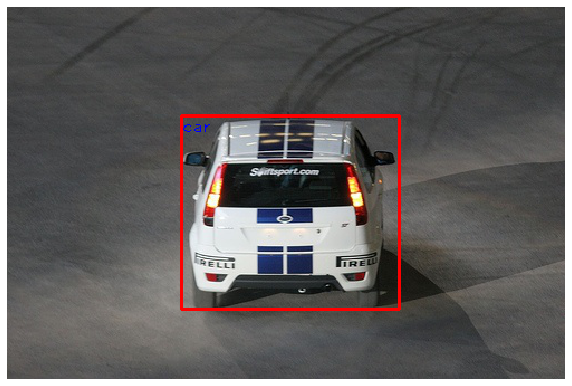

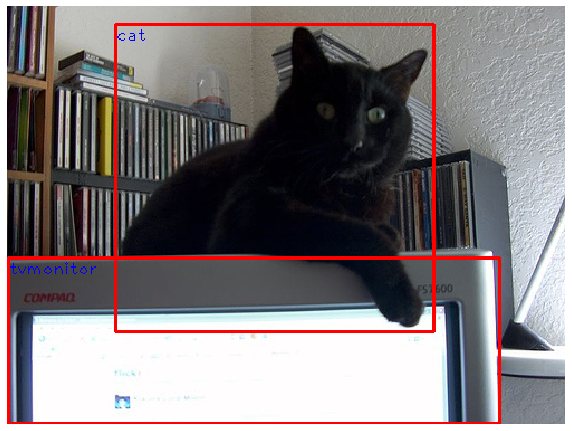

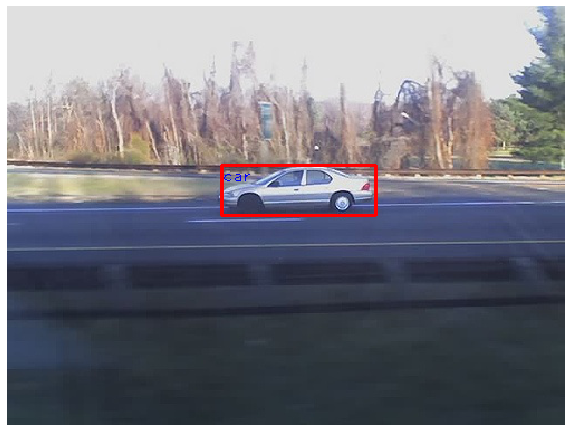

In [10]:
# visualize GT boxes
for i in range(len(img_list)):
    valid_box = sum([1 if j != -1 else 0 for j in box_list[i][:, 0]])
    detection_visualizer(img_list[i], idx_to_class, box_list[i][:valid_box])

# 03-Detector Backbone Network
Here, we use [MobileNet v2](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/) for image feature extraction. The code is based on Assignment 4-2. The function is included in a5_helper and can be seen below. 

```python
class FeatureExtractor(nn.Module):
  """
  Image feature extraction with MobileNet.
  """
  def __init__(self, reshape_size=224, pooling=False, verbose=False):
    super().__init__()

    self.mobilenet = models.mobilenet_v2(pretrained=True)
    self.mobilenet = nn.Sequential(*list(self.mobilenet.children())[:-1]) 

    # average pooling
    if pooling:
      self.mobilenet.add_module('LastAvgPool', nn.AvgPool2d(math.ceil(reshape_size/32.))) # input: N x 1280 x 7 x 7

    for i in self.mobilenet.named_parameters():
      i[1].requires_grad = True # fine-tune all parameters

    if verbose:
      summary(self.mobilenet.cuda(), (3, reshape_size, reshape_size))
  
  def forward(self, img, verbose=False):
    """
    Inputs:
    - img: Batch of resized images, of shape Nx3x224x224
    
    Outputs:
    - feat: Image feature, of shape Nx1280 (pooled) or Nx1280x7x7
    """
    num_img = img.shape[0]
    
    img_prepro = img

    feat = []
    process_batch = 500
    for b in range(math.ceil(num_img/process_batch)):
      feat.append(self.mobilenet(img_prepro[b*process_batch:(b+1)*process_batch]
                              ).squeeze(-1).squeeze(-1)) # forward and squeeze
    feat = torch.cat(feat)
    
    if verbose:
      print('Output feature shape: ', feat.shape)
    
    return feat
```

Now, let's see what's inside MobileNet v2. Assume we have a 3x224x224 image input.

In [ ]:
model = FeatureExtractor(verbose=True)

# 04-Anchor and Proposal
The concept of *anchor* is introduced in [Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf) and later used in numerous later works including [YOLO v2](https://arxiv.org/pdf/1612.08242.pdf). The definition of anchor from the original paper is summarized as follows:

After passing the input image through the backbone network, we have a convolutional feature map of shape $(C, 7, 7)$ which we interpret as a 7x7 grid of $C$-dimensional features. At each point in this grid, we consider a set of $A$ *anchor boxes* of different sizes and shapes; for each anchor box we classify it as either an object or background box. The total number of anchor boxes that we consider for the entire input image is $(A, 7, 7)$; we predict classification scores of this shape by applying a sequence of convolutional layers to the backbone features.

We slide a small network (e.g., 3x3 conv layer) over the CNN activation feature map. We call this 3x3 conv a sliding window. At each sliding-window location (i.e., centered at each position of the 7x7 activation cell), we simultaneously predict multiple region *proposals*, where the number of proposals for each location is denoted as $A=9$.

Later, we will have an object proposal layer outputs
A-D scores that estimate probability of object for each proposal, a bounding box regression layer to produce 4A-D outputs encoding
the coordinates of A boxes, and a region classification layer to produce 20-D outputs indicating the probability of being each object category (shared by all A anchors). The A *proposals* are parameterized relative to A reference boxes, which we call *anchors*. An anchor is centered at the sliding window in question, and is associated with a shape (e.g., 1x1, 3x3, 5x5). The list of anchor shapes are provided next.






## Anchor shapes
At each spatial position of the 7x7 backbone features, we consider a set of $A$ anchor boxes. Different spatial positions all use anchors of the same shape.

The shapes of the anchor boxes are a hyperparameter. We will provide the anchor shapes for you, and we will re-use the same anchor shapes for both A5-1 and A5-2. In some papers (e.g. YOLO v2), the anchor shapes are determined in a data-driven way by clustering the set of ground-truth box sizes, but for simplicity we will not use that approach in this assignment.

Note that anchors could be much larger than the 3x3 sliding window (e.g., 5x5) since the receptive field of activation cell on the original image could be large.

In [ ]:
# Declare variables for anchor priors, a Ax2 Tensor where A is the number of anchors.
# Hand-picked, same as our two-stage detector.
anchor_list = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [2, 3], [3, 2], [3, 5], [5, 3]]).float().cuda()
print(anchor_list.shape)

## Activation Grid Generator
In order to place anchors centered at each position of the 7x7 grid of backbone features, we need to know the spatial position of the center of each cell in the 7x7 grid of features.

This function will compute these center coordinates for us.

```python
def GenerateGrid(batch_size, w_amap=7, h_amap=7, dtype=torch.float32, device='cuda'):
  """
  Return a grid cell given a batch size (center coordinates).

  Inputs:
  - batch_size, B
  - w_amap: or W', width of the activation map (number of grids in the horizontal dimension)
  - h_amap: or H', height of the activation map (number of grids in the vertical dimension)
  - W' and H' are always 7 in our case while w and h might vary.
  
  Outputs:
  grid: A float32 tensor of shape (B, H', W', 2) giving the (x, y) coordinates
        of the centers of each feature for a feature map of shape (B, D, H', W')
  """
  w_range = torch.arange(0, w_amap, dtype=dtype, device=device) + 0.5
  h_range = torch.arange(0, h_amap, dtype=dtype, device=device) + 0.5

  w_grid_idx = w_range.unsqueeze(0).repeat(h_amap, 1)
  h_grid_idx = h_range.unsqueeze(1).repeat(1, w_amap)
  grid = torch.stack([w_grid_idx, h_grid_idx], dim=-1)
  grid = grid.unsqueeze(0).repeat(batch_size, 1, 1, 1)

  return grid
```

We now visualize its output.

In [ ]:
# visualization
# simply create an activation grid where the cells are in green and the centers in red
# you should see the entire image divided by a 7x7 grid, with no gaps on the edges

grid_list = GenerateGrid(w_list.shape[0])

center = torch.cat((grid_list, grid_list), dim=-1)
grid_cell = center.clone()
grid_cell[:, :, :, [0, 1]] -= 1. / 2.
grid_cell[:, :, :, [2, 3]] += 1. / 2.
center = coord_trans(center, w_list, h_list)
grid_cell = coord_trans(grid_cell, w_list, h_list)

for img, anc, grid in zip(img_list, center, grid_cell):
  detection_visualizer(img, idx_to_class, anc.reshape(-1, 4), grid.reshape(-1, 4))

## Anchor Generator
At this point we have defined the spatial sizes of anchors that we consider at each grid point, and we have computed the center of each grid point. We now combine these two pieces of information to compute the positions of all anchor boxes for the entire image.


We denote the anchor coordinates as ($x_{tl}^a$, $y_{tl}^a$, $x_{br}^a$, $y_{br}^a$), indicating the coordinates of the top-left corner and the bottom-right corner accordingly. The following function returns all the anchors given the anchor shapes and the grid cell. **Note that the center of an anchor overlaps a grid cell center.**

Run the following to check your implementation. You should see errors on the order of 1e-8 or less.

In [ ]:
from single_stage_detector import GenerateAnchor

# sanity check
anc_list = GenerateAnchor(anchor_list, grid_list)
assert anc_list.shape == torch.Size([3, 9, 7, 7, 4]), 'shape mismatch!'

expected_anc_list_mean = torch.tensor([[-1.25000000, -0.87500000,  2.25000000,  1.87500000],
                                       [ 1.75000000, -0.87500000,  5.25000000,  1.87500000],
                                       [ 4.75000000, -0.87500000,  8.25000000,  1.87500000],
                                       [-1.25000000,  1.12500000,  2.25000000,  3.87500000],
                                       [ 1.75000000,  1.12500000,  5.25000000,  3.87500000],
                                       [ 4.75000000,  1.12500000,  8.25000000,  3.87500000],
                                       [-1.25000000,  3.12500000,  2.25000000,  5.87500000],
                                       [ 1.75000000,  3.12500000,  5.25000000,  5.87500000],
                                       [ 4.75000000,  3.12500000,  8.25000000,  5.87500000],
                                       [-1.25000000,  5.12500000,  2.25000000,  7.87500000],
                                       [ 1.75000000,  5.12500000,  5.25000000,  7.87500000],
                                       [ 4.75000000,  5.12500000,  8.25000000,  7.87500000]], dtype=torch.float32, device='cuda')
print('rel error: ', rel_error(expected_anc_list_mean, anc_list[0, [1,3,6,8], ::2, ::3, :].view(-1, 12, 4).mean(0)))

In [ ]:
# visualization
print('*'*80)
print('All nine anchors should be exactly centered:')
anc_list = GenerateAnchor(anchor_list, grid_list[:, 3:4, 3:4])
for img, anc in zip(img_list, coord_trans(anc_list, w_list, h_list)):
  print(anc.shape)
  detection_visualizer(img, idx_to_class, anc.reshape(-1, 4))

print('*'*80)
print('All anchors of the image (cluttered):')
anc_list = GenerateAnchor(anchor_list, grid_list) # all
for img, anc in zip(img_list, coord_trans(anc_list, w_list, h_list)):
  print(anc.shape)
  detection_visualizer(img, idx_to_class, anc.reshape(-1, 4))

## Proposal Generator
If we only use anchors to propose object locations, we can only cover 9x7x7=441 regions in the image. What if an object does not fall into any of the regions?

Hence, in the recent literatures (e.g., [Fast R-CNN](https://arxiv.org/pdf/1504.08083.pdf)), the detector predicts transformations that convert anchor boxes into *region proposals*.

So far, we have represented anchors boxes by the coordinates of their top-left and bottom-right corners $(x_{tl}^a, y_{tl}^a, x_{br}^a, y_{br}^a)$. When converting anchors to proposals, it will be more convenient to parameterize boxes by the xy coordinate of their center, and their with and height: $(x_c^a,y_c^a,w^a,h^a)$.

Now, consider an anchor box with center, width and height $(x_c^a,y_c^a,w^a,h^a)$.
The network will predict a *transformation* $(t^x, t^y, t^w, t^h)$; applying this transformation to the anchor yields a *region proposal* with center, width and height $(x_c^p,y_c^p,w^p,h^p)$.
YOLO and Faster R-CNN use slightly different formulas to convert anchors into proposals. Here you need to implement both formulations.

### YOLO
For YOLO, we assume that $t^x$ and $t^y$ are both in the range $-0.5\leq t^x,t^y\leq 0.5$, while $t^w$ and $t^h$ are real numbers in the range $(-\infty, \infty)$. Then we have:
- $x_c^p = x_c^a + t^x$
- $y_c^p = y_c^a + t^y$
- $w^p = w_a exp(t^w)$
- $h^p = h_a exp(t^h)$

### Faster R-CNN
For Faster R-CNN, we assume that all transformation parameters $t^x, t^y, t^w, t_h$ are real numbers in the range $(-\infty, \infty)$. Then we have:
- $x_c^p = x_c^a + t^xw^a$
- $y_c^p = y_c^p + t^yh^a$
- $w^p = w_a exp(t^w)$
- $h^p = h_a exp(t^h)$


### Training
During training, we compute the ground-truth transformation $(\hat{t^x}, \hat{t^y}, \hat{t^w}, \hat{t^h})$ that would transform the anchor box $(x_c^a,y_c^a,w^a,h^a)$ into the the ground-truth box $(x_c^{gt},y_c^{gt},w^{gt},h^{gt})$. We then apply a regression loss that penalizes differences between the predicted transform $(t^x, t^y, t^w, t^h)$ and the ground-truth transform.


Run the following to check your implementation. You should see errors on the order of 1e-7 or less.


In [ ]:
from single_stage_detector import GenerateProposal

print('-' * 80)
print('Sanity check for YOLO.')
yolo_offset_list = torch.cat([torch.ones_like(anc_list[:, :, :, :, 0:2]).fill_(.5), torch.ones_like(anc_list[:, :, :, :, 2:4])], dim=-1)
yolo_proposal_list = GenerateProposal(anc_list, yolo_offset_list, 'YOLO') # no scaling

print('1. Center moved by ~0.5 cell')
print('rel error: ', rel_error(anc_list[0, 0, 0, :, 0:2] + (anc_list[0, 0, 0, :, 2:4] - anc_list[0, 0, 0, :, 0:2])/2.0 + 0.5, \
                               (yolo_proposal_list[0, 0, 0, :, 0:2] + (yolo_proposal_list[0, 0, 0, :, 2:4] - yolo_proposal_list[0, 0, 0, :, 0:2]) / 2.0)))

print('2. w/h changed by e')
print('rel error: ', rel_error((anc_list[0, 0, 0, :, 2:4] - anc_list[0, 0, 0, :, 0:2]) * torch.exp(torch.ones_like(anc_list[0, 0, 0, :, 0:2])), \
      (yolo_proposal_list[0, 0, 0, :, 2:4] - yolo_proposal_list[0, 0, 0, :, 0:2])))


print('-' * 80)
print('Sanity check for FasterRCNN.')
rcnn_offset_list = torch.ones_like(anc_list)
rcnn_proposal_list = GenerateProposal(anc_list, rcnn_offset_list, 'FasterRCNN')

print('1. x/y shifted by wh')
print('rel error: ', rel_error(anc_list[0, 0, 0, :, 0:2] + (anc_list[0, 0, 0, :, 2:4] - anc_list[0, 0, 0, :, 0:2]) * 3.0 /2.0, \
      (rcnn_proposal_list[0, 0, 0, :, 0:2] + (rcnn_proposal_list[0, 0, 0, :, 2:4] - rcnn_proposal_list[0, 0, 0, :, 0:2]) / 2.0)))

print('2. w/h should changed by e')
print('rel error: ', rel_error((anc_list[0, 0, 0, :, 2:4] - anc_list[0, 0, 0, :, 0:2]) * torch.exp(torch.ones_like(anc_list[0, 0, 0, :, 0:2])), \
      (rcnn_proposal_list[0, 0, 0, :, 2:4] - rcnn_proposal_list[0, 0, 0, :, 0:2])))

As an additional sanity check, we visualize an anchor (in red) and the corresponding proposal (in green) that results from applying the transform $(0.5, 0.5, 0, 0)$. The proposal should shift down and to the right (when using the YOLO formulation).

In [ ]:
yolo_offset_list = torch.cat([torch.ones_like(anc_list[:, :, :, :, 0:2]).fill_(.5), torch.zeros_like(anc_list[:, :, :, :, 2:4])], dim=-1)
yolo_proposal_list = GenerateProposal(anc_list, yolo_offset_list, 'YOLO')

for img, anc, prop in zip(img_list, coord_trans(anc_list[:, 0:1, 3:4, 3:4, :], w_list, h_list), \
                          coord_trans(yolo_proposal_list[:, 0:1, 3:4, 3:4, :], w_list, h_list)):
  detection_visualizer(img, idx_to_class, anc.reshape(-1, 4), prop.reshape(-1, 4))

Next we visualize the effect of applying the transform $(0, 0, 1, 1)$ (with the YOLO formula) to the same anchor box (in red). Now the proposal (in green) should have the same center as the anchor, but the proposal should be larger.

In [ ]:
yolo_offset_list = torch.cat([torch.zeros_like(anc_list[:, :, :, :, 0:2]), torch.ones_like(anc_list[:, :, :, :, 2:4]).fill_(1.)], dim=-1)
yolo_proposal_list = GenerateProposal(anc_list, yolo_offset_list, 'YOLO')

for img, anc, prop in zip(img_list, coord_trans(anc_list[:, 0:1, 3:4, 3:4, :], w_list, h_list), \
                          coord_trans(yolo_proposal_list[:, 0:1, 3:4, 3:4, :], w_list, h_list)):
  detection_visualizer(img, idx_to_class, anc.reshape(-1, 4), prop.reshape(-1, 4))

Next to sanity-check our implementation of the Faster R-CNN transformation formulas, we visualize the effect of applying the transform $(1, 1, 0, 0)$ to the same anchor (in red). The proposal (in green) should shift down and to the right by an amount equal to the size of the anchor.

In [ ]:
# visualization (shift by wh, Faster R-CNN)
# anchors in red and proposals in green
rcnn_offset_list = torch.cat([torch.ones_like(anc_list[:, :, :, :, 0:2]), torch.zeros_like(anc_list[:, :, :, :, 2:4])], dim=-1)
rcnn_proposal_list = GenerateProposal(anc_list, rcnn_offset_list, 'FasterRCNN')

for img, anc, prop in zip(img_list, coord_trans(anc_list[:, 0:1, 3:4, 3:4, :], w_list, h_list), \
                          coord_trans(rcnn_proposal_list[:, 0:1, 3:4, 3:4, :], w_list, h_list)):
  detection_visualizer(img, idx_to_class, anc.reshape(-1, 4), prop.reshape(-1, 4))

We further check our implementation of the Faster R-CNN transformation formula, and visualize the effect of applying the transformation $(0, 0, 1, 1)$ to the same anchor. Now the proposal (in green) should have the same center as the anchor (in red), but the proposal should be larger by a factor of $e$.

In [ ]:
# visualization (no shift and then scale by e, Faster R-CNN)
# anchors in red and proposals in green
rcnn_offset_list = torch.cat([torch.zeros_like(anc_list[:, :, :, :, 0:2]), torch.ones_like(anc_list[:, :, :, :, 2:4]).fill_(1)], dim=-1)
rcnn_proposal_list = GenerateProposal(anc_list, rcnn_offset_list, 'FasterRCNN')

for img, anc, prop in zip(img_list, coord_trans(anc_list[:, 0:1, 3:4, 3:4, :], w_list, h_list), \
                          coord_trans(rcnn_proposal_list[:, 0:1, 3:4, 3:4, :], w_list, h_list)):
  detection_visualizer(img, idx_to_class, anc.reshape(-1, 4), prop.reshape(-1, 4))

# 05-Prediction Networks
This module outputs the prediction scores (see figure below). We have provided the code to determine activated/negative anchors for you, though you need to implement the IoU function for it to work. You will also need to compute the loss function. The loss function consists of three parts, confidence score regression, bounding box offsets regression, and object classication.

![pred_scores](https://miro.medium.com/max/1055/1*YG6heD55fEmZeUKRSlsqlA.png)


Image credit: [towardsdatascience](https://towardsdatascience.com/yolov1-you-only-look-once-object-detection-e1f3ffec8a89). In this example, number of anchor shapes is $A=2$ while we have $A=9$.

## Intersection Over Union (IoU)
The definition of IoU and instructions on how to compute IoU can be found in the lecture slides (p35-39): https://web.eecs.umich.edu/~justincj/slides/eecs498/FA2020/598_FA2020_lecture15.pdf

Run the following to check your implementation. You should see errors on the order of 1e-8 or less.

In [ ]:
from single_stage_detector import IoU

# simple sanity check
width = torch.tensor([35, 35], dtype=torch.float32, device='cuda')
heigh = torch.tensor([40, 40], dtype=torch.float32, device='cuda')
sample_bbox = torch.tensor([[[1,1,11,11,0], [20,20,30,30,0]]], dtype=torch.float32, device='cuda')
sample_proposals = torch.tensor([[[[[5,5,15,15], [27,27,37,37]]]]], dtype=torch.float32, device='cuda')


result = IoU(sample_proposals, sample_bbox)

# check 1
expected_result = torch.tensor([[[0.21951219, 0.00000000],
                                 [0.00000000, 0.04712042]]], dtype=torch.float32, device='cuda')
print('simple iou_mat error: ', rel_error(expected_result, result))

# check 2
iou_mat = IoU(anc_list, resized_box_list)
expected_iou_mat = torch.tensor([0.11666405, 0.15146968, 0.02956639], dtype=torch.float32, device='cuda')
print('iou_mat error: ', rel_error(expected_iou_mat, iou_mat[:, :, 0].mean(1)))

## Activated (positive) and negative anchors
During training we need to match the ground-truth boxes against the anchors to determine the classification labels for the anchors -- which anchors should be classified as containing an object and which should be classified as background? We have written this part for you.

Read and digest the input/output definition carefully. You are highly recommended to read through the code as later parts rely heavily on this function.

The function `ReferenceOnActivatedAnchors` is implemented in `a5_helper.py`.

Run the following to check your implementation. You should see errors on the order of 1e-7 or less.

In [ ]:
# sanity check on YOLO (the one on Faster R-CNN is in A5-2)
activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, \
  activated_anc_coord, negative_anc_coord = ReferenceOnActivatedAnchors(anc_list, resized_box_list, grid_list, iou_mat, neg_thresh=0.2, method='YOLO')

expected_GT_conf_scores = torch.tensor([0.74538743, 0.72793430, 0.76044953, 0.37116671], device='cuda', dtype=torch.float32)
expected_GT_offsets = torch.tensor([[ 0.04900002,  0.35735703, -0.09431065,  0.19244696],
                                    [-0.14700007,  0.37299442, -0.00250307,  0.25213102],
                                    [-0.40600014,  0.09625626,  0.20863886, -0.07974572],
                                    [ 0.15399981, -0.42933345, -0.03459148, -0.86750042]], device='cuda', dtype=torch.float32)
expected_GT_class = torch.tensor([ 6,  7, 19,  6], device='cuda', dtype=torch.int64)
print('conf scores error: ', rel_error(GT_conf_scores, expected_GT_conf_scores))
print('offsets error: ', rel_error(GT_offsets, expected_GT_offsets))
print('class prob error: ', rel_error(GT_class, expected_GT_class))

We can sanity check this function by visualizing ground-truth boxes (in red) along with positive / negative anchors (in green).

In [ ]:
# visualize activated and negative anchors
anc_per_img = torch.prod(torch.tensor(anc_list.shape[1:-1]))

print('*'*80)
print('Activated (positive) anchors:')
for img, bbox, idx in zip(img_list, box_list, torch.arange(box_list.shape[0])):
  anc_ind_in_img = (activated_anc_ind >= idx * anc_per_img) & (activated_anc_ind < (idx+1) * anc_per_img)
  print('{} activated anchors!'.format(torch.sum(anc_ind_in_img)))
  detection_visualizer(img, idx_to_class, bbox[:, :4], coord_trans(activated_anc_coord[anc_ind_in_img], w_list[idx], h_list[idx]))

print('*'*80)
print('Negative anchors:')
for img, bbox, idx in zip(img_list, box_list, torch.arange(box_list.shape[0])):
  anc_ind_in_img = (negative_anc_ind >= idx * anc_per_img) & (negative_anc_ind < (idx+1) * anc_per_img)
  print('{} negative anchors!'.format(torch.sum(anc_ind_in_img)))
  detection_visualizer(img, idx_to_class, bbox[:, :4], coord_trans(negative_anc_coord[anc_ind_in_img], w_list[idx], h_list[idx]))

## Prediction Network
The prediction network inputs the features from the backbone network, and outputs the classification scores and transformations for each anchor.

For each position in the 7x7 grid of features from the backbone, the prediction network outputs `C` numbers to be interpreted as classification scores over the `C` object categories for the anchors at that position.

In addition, for each of the `A` anchors at each position, the prediction network outputs a transformation (4 numbers, to convert the anchor box into a region proposal) and a confidence score (where large positive values indicate high probability that the anchor contains an object, and large negative values indicate low probability that the anchor contains an object).

Collecting all of these outputs, we see that for each position in the 7x7 grid of features we need to output a total of `5A+C` numbers, so the prediction network receives an input tensor of shape `(B, 1280, 7, 7)` and produces an output tensor of shape `(B, 5A+C, 7, 7)`. We can achieve this with two `1x1` convolution layers operating on the input tensor, where the number of filters in the second layer is `5A+C`.

During training, we do not apply the loss on the full set of anchor boxes for the image; instead we designate a subset of anchors as positive and negative by matching them with ground-truth boxes as in the function above. The Prediction network is also responsible for picking out the outputs corresponding to the positive and negative anchors.

Implement `PredictionNetwork` in `single_stage_detector.py` and run the following to check your implementation. You should see errors on the order of 1e-7 or less.

In [ ]:
from single_stage_detector import PredictionNetwork

# sanity check
reset_seed(0)
pred_network = PredictionNetwork(1280, drop_ratio=0).to(dtype=torch.float32, device='cuda')
features = torch.linspace(-10., 10., steps=3*1280*7*7, dtype=torch.float32, device='cuda').view(3, 1280, 7, 7)
pos_anchor_idx = torch.tensor([122, 605, 871, 955], dtype=torch.int64, device='cuda')
neg_anchor_idx = torch.tensor([1048, 1292, 1124, 1092], dtype=torch.int64, device='cuda')
conf_scores, offsets, class_prob = pred_network(features, pos_anchor_idx, neg_anchor_idx)

expected_conf_scores = torch.tensor([[0.85080749], [0.55230302], [0.45239496], [0.51819414],
                                     [0.38467780], [0.82627463], [0.53837817], [0.538446366]], dtype=torch.float32, device='cuda')
expected_offsets = torch.tensor([[-0.16344640,  0.45598251, -1.56108809, -1.96177566],
                                 [ 0.09087485, -0.11321104,  0.46109992,  0.13557276],
                                 [ 0.14098871, -0.04003078, -0.14689390,  0.01480492],
                                 [-0.22611487,  0.14513946, -1.26124716,  0.58137202]], dtype=torch.float32, device='cuda')
expected_class_prob = torch.tensor([0.88649291, 1.08752346, 0.90241265, 1.28021181, 0.77324629,
                                    -0.93609941, 1.44269419, -1.01072836, 0.09888625, -0.09179375,
                                    -0.48814785, -1.14749694, 0.24533349, -0.19522685, 0.21445289,
                                    0.91779679, 0.97305167, 1.01984429, -0.11932681, 0.34998628], dtype=torch.float32, device='cuda')

print('conf scores error: ', rel_error(conf_scores, expected_conf_scores))
print('offsets error: ', rel_error(offsets, expected_offsets))
print('class prob error: ', rel_error(class_prob.mean(0), expected_class_prob))

## Loss Function
The confidence score regression loss is for both activated/negative anchors while the bounding box regression loss and the object classification loss are for activated anchors only. These are implemented for you. You can see the functions `ConfScoreRegression` and `BboxRegression` in `single_stage_detector.py`, and `ObjectClassification` in `a5_helper.py`.

Run the following to check your implementation. You should see errors on the order of 1e-8 or less.

In [ ]:
# sanity check
from single_stage_detector import ConfScoreRegression, BboxRegression


conf_loss = ConfScoreRegression(conf_scores, GT_conf_scores)
reg_loss = BboxRegression(offsets, GT_offsets)
cls_loss = ObjectClassification(class_prob, GT_class, w_list.shape[0], anc_per_img, activated_anc_ind)
print('conf loss: {:.4f}, reg loss: {:.4f}, cls loss: {:.4f}'.format(conf_loss, reg_loss, cls_loss))

loss_all = torch.tensor([conf_loss.data, reg_loss.data, cls_loss.data], device='cuda', dtype=torch.float32)
expected_loss = torch.tensor([0.27064770460128784, 2.9750006198883057, 2.3919472694396973], device='cuda', dtype=torch.float32)

print('loss error: ', rel_error(loss_all, expected_loss))

# 06-Train an object detector

## Object detection module

We will now combine everything into the `SingleStageDetector` class in `single_stage_detector.py`. Implement the `forward` function of our detector. This implements the training-time forward pass: it receives the input images and the ground-truth bounding boxes, and returns the total loss for the minibatch.

## Overfit small data
To make sure that everything is working as expected, we can try to overfit the detector to a small subset of data.

After 200 epochs of training you should see a total loss of around or less than 0.3.


We also implemented the `DetectionSolver` object which runs the training loop to train an single stage detector. You can inspect the DetectionSolver implementation in `single_stage_detector.py`. 

In [ ]:
from single_stage_detector import DetectionSolver, SingleStageDetector

# monitor the training loss
reset_seed(0)
num_sample = 10
small_dataset = torch.utils.data.Subset(train_dataset, torch.linspace(0, len(train_dataset)-1, steps=num_sample).long())
small_train_loader = pascal_voc2007_loader(small_dataset, 10) # a new loader

for lr in [1e-2]:
  print('lr: ', lr)
  detector = SingleStageDetector()
  DetectionSolver(detector, small_train_loader, learning_rate=lr, num_epochs=200, dtype=torch.float32, device='cuda')

## Train a net

Now that we are confident that the training code is working properly, let's train the network on more data and for longer. We will train for 50 epochs; this should take about 35 minutes on a K80 GPU. You should see a total loss around or less than 0.27.

For initial debugging, you may want to train for a smaller number of epochs; training for 5 epochs, you can expect a loss of around 1.0. 

Note that real object detection systems typically train for 12-24 hours, distribute training over multiple GPUs, and use much faster GPUs. As such our result will be far from the state of the art, but it should give some reasonable results!


In [ ]:
# monitor the training loss
train_loader = pascal_voc2007_loader(train_dataset, 100)

lr = 5e-2
num_epochs = 50
yolo_detector = SingleStageDetector().to(dtype=torch.float32, device='cuda')
DetectionSolver(yolo_detector, train_loader, learning_rate=lr, num_epochs=num_epochs, dtype=torch.float32, device='cuda')

After you've trained your model, save the weights for submission. Feel free to comment some of those lines to load earlier checkpoints. We evaluate the detector after loading as a sanity check.

In [ ]:
weights_path = os.path.join(GOOGLE_DRIVE_PATH, "yolo_detector.pt")
torch.save(yolo_detector.state_dict(), weights_path)

yolo_detector = SingleStageDetector().to(dtype=torch.float32, device='cuda')
yolo_detector.load_state_dict(torch.load(weights_path))
DetectionEvaluater(yolo_detector, train_loader, dtype=torch.float32, device='cuda')


# 07-Use an object detector

## Non-Maximum Suppression (NMS)
The definition of NMS and instructions on how to compute NMS can be found in the lecture slides (p40-44):
https://web.eecs.umich.edu/~justincj/slides/eecs498/FA2020/598_FA2020_lecture15.pdf

Implement the `nms` function in `single_stage_detector.py`. We then compare your implementation of NMS with the implementation in torchvision. Most likely, your implementation will be faster on CPU than on CUDA, and the torchvision implementation will likely be much faster than yours. This is expected, but your implementation should produce the same outputs as the torchvision version.

In [ ]:
from single_stage_detector import nms

reset_seed(0)
boxes = (100. * torch.rand(5000, 4)).round()
boxes[:,2] = boxes[:,2] + boxes[:,0] + 1.
boxes[:,3] = boxes[:,3] + boxes[:,1] + 1.
scores = torch.randn(5000)

names = ['your_cpu', 'torchvision_cpu', 'torchvision_cuda']
iou_thresholds = [0.3, 0.5, 0.7]
elapsed = dict(zip(names, [0.]*len(names)))
intersects = dict(zip(names[1:], [0.]*(len(names)-1)))

for iou_threshold in iou_thresholds:
  tic = time.time()
  my_keep = nms(boxes, scores, iou_threshold)
  elapsed['your_cpu'] += time.time() - tic
 
  tic = time.time()
  tv_keep = torchvision.ops.nms(boxes, scores, iou_threshold)
  elapsed['torchvision_cpu'] += time.time() - tic
  intersect = len(set(tv_keep.tolist()).intersection(my_keep.tolist())) / len(tv_keep)
  intersects['torchvision_cpu'] += intersect

  tic = time.time()
  tv_cuda_keep = torchvision.ops.nms(boxes.cuda(), scores.cuda(), iou_threshold).to(my_keep.device)
  torch.cuda.synchronize()
  elapsed['torchvision_cuda'] += time.time() - tic
  intersect = len(set(tv_cuda_keep.tolist()).intersection(my_keep.tolist())) / len(tv_cuda_keep)
  intersects['torchvision_cuda'] += intersect

for key in intersects:
  intersects[key] /= len(iou_thresholds)

# You should see < 1% difference
print('Testing NMS:')
print('Your        CPU  implementation: %fs' % elapsed['your_cpu'])
print('torchvision CPU  implementation: %fs' % elapsed['torchvision_cpu'])
print('torchvision CUDA implementation: %fs' % elapsed['torchvision_cuda'])
print('Speedup CPU : %fx' % (elapsed['your_cpu'] / elapsed['torchvision_cpu']))
print('Speedup CUDA: %fx' % (elapsed['your_cpu'] / elapsed['torchvision_cuda']))
print('Difference CPU : ', 1. - intersects['torchvision_cpu']) # in the order of 1e-3 or less
print('Difference CUDA: ', 1. - intersects['torchvision_cuda']) # in the order of 1e-3 or less

## Inference

Now, implement the inference part of module `SingleStageDetector`. Once you're done, test your implementation using the overfitted model weights. 

Visualize the output from the overfitted model on the small dataset by running the code box below, the bounding boxes should be really accurate.

In [ ]:
DetectionInference(detector, small_train_loader, small_dataset, idx_to_class, thresh=0.8, device='cuda', dtype=torch.float32)

### Inference - train a net

In [ ]:
# visualize the same output from the model trained on the entire training set
# some bounding boxes might not make sense
DetectionInference(yolo_detector, small_train_loader, small_dataset, idx_to_class, dtype=torch.float32, device='cuda')

## Evaluation
Compute mean Average Precision (mAP). Introduction on mAP see lecture slides (p46-57): https://web.eecs.umich.edu/~justincj/slides/eecs498/FA2020/598_FA2020_lecture15.pdf


Run the following to evaluate your detector on the PASCAL VOC validation set. You should see mAP at around 11% or above.

The state of the art on this dataset is >80% mAP! To achieve these results we would need to use a much bigger network, and train with more data and for much longer, but that is beyond the scope of this assigment.

(Optional) If you train the model longer (e.g., 100 epochs), you should see a better mAP. But make sure you revert the code back for grading purposes.

In [ ]:
DetectionInference(yolo_detector, val_loader, val_dataset, idx_to_class, output_dir='mAP/input', thresh=0.8, nms_thresh=0.3, device='cuda', dtype=torch.float32)
!cd mAP && python main.py